In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import pickle
from collections import Counter
from scipy.signal import butter, filtfilt

In [95]:
# taking fs =32 as there is 32 signal every sec  
def bandpass_filter(signal, fs, low=0.17, high=0.4, order=4):
    nyquist = 0.5 * fs
    low_n = low / nyquist
    high_n = high / nyquist

    b, a = butter(order, [low_n, high_n], btype='band')
    filtered = filtfilt(b, a, signal)

    return filtered

In [96]:
# Split the signals into 30-second windows with 50% overlap
def generate_windows(df, fs, window_sec=30, overlap=0.5):
    window_samples = int(window_sec * fs)
    stride_samples = int(window_samples * (1 - overlap)) #This determines how much the window moves each step.

    values = df["value"].values
    times = df.index

    windows = []

    for start in range(0, len(values) - window_samples + 1, stride_samples):
        end = start + window_samples

        win_signal = values[start:end]
        start_time = times[start]
        end_time = times[end - 1]

        windows.append((start_time, end_time, win_signal))

    return windows

In [97]:
# Assign label to window based on overlap with events.
def get_window_label(win_start, win_end, events, threshold_ratio=0.5):

    window_duration = (win_end - win_start).total_seconds()
    threshold = threshold_ratio * window_duration

    best_label = "Normal"
    best_overlap = 0

    for ev_start, ev_end, ev_label in events:
        overlap_start = max(win_start, ev_start)
        overlap_end = min(win_end, ev_end)

        overlap = (overlap_end - overlap_start).total_seconds()
# if there is multiple overlap the return only best one 
        if overlap > best_overlap:
            best_overlap = overlap
            best_label = ev_label

    if best_overlap >= threshold:
        return best_label
    else:
        return "Normal"

In [98]:
def find_file(folder, keyword, exclude=None):
#  this function helps to find file name i have use this because file names sre dirrent in folders 
    matches = []
    for fname in os.listdir(folder):
        name = fname.lower()

        if keyword.lower() in name:
            if exclude and exclude.lower() in name:
                continue
            matches.append(fname)

    if len(matches) == 0:
        print(f"\n Files in {folder}:")
        for f in os.listdir(folder):
            print("   ", f)
        raise FileNotFoundError(f" '{keyword}' not found in {folder}")
        
# if mpre then one file name matches then raise error
    if len(matches) > 1:
        raise ValueError(f"Multiple '{keyword}' files found in {folder}")

    chosen = matches[0]
    print(f" Matched [{keyword}] to {chosen}")

    return os.path.join(folder, chosen)

In [99]:
# this fun returns pandas DataFrame
def parse_signal_txt(file_path):
    timestamps = []
    values = []

    with open(file_path, "r") as f:
        lines = f.readlines()

# Find where data starts 
    data_start = None
    for i, line in enumerate(lines):
        if line.strip() == "Data:":
            data_start = i + 1
            break

    if data_start is None:
        raise ValueError(f"'Data:' not found in {file_path}")

    for line in lines[data_start:]:
        line = line.strip()
        if not line:
            continue

        try:
            ts_str, val = line.split(";")
            ts = datetime.strptime(ts_str.strip(), "%d.%m.%Y %H:%M:%S,%f")
            val = float(val.strip())

            timestamps.append(ts)
            values.append(val)
        except Exception:
            continue

    df = pd.DataFrame({"value": values}, index=pd.to_datetime(timestamps))
    # print(df.head())
    
    return df

In [100]:
# this fun is for file  Flow Events 
def parse_flow_events(file_path):
    events = []

    with open(file_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()

        if "-" not in line or ";" not in line:
            continue

        try:
            time_part, _, label, _ = line.split(";")
            start_str, end_time_str = time_part.split("-")

            start_dt = datetime.strptime(
                start_str.strip(), "%d.%m.%Y %H:%M:%S,%f"
            )

            # reconstruct end datetime using same date
            end_dt = datetime.strptime(
                start_dt.strftime("%d.%m.%Y") + " " + end_time_str.strip(),
                
                "%d.%m.%Y %H:%M:%S,%f",
            )

            events.append((start_dt, end_dt, label.strip()))

        except Exception:
            continue
    return events

In [101]:
# Convert participant into labeled windows.
def p_participant(participant_dir, participant_id):

    # locate files (your robust finder)
    airflow_path = find_file(participant_dir, "flow", exclude="event")
    thoracic_path = find_file(participant_dir, "thorac")
    spo2_path = find_file(participant_dir, "spo2")
    events_path = find_file(participant_dir, "flow events")

# load signals
    airflow_df = parse_signal_txt(airflow_path)
    thoracic_df = parse_signal_txt(thoracic_path)
    spo2_df = parse_signal_txt(spo2_path)
    events = parse_flow_events(events_path)

#apply bandpass to respiration
    airflow_df["value"] = bandpass_filter(airflow_df["value"].values, fs=32)
    thoracic_df["value"] = bandpass_filter(thoracic_df["value"].values, fs=32)

#generate windows
    airflow_windows = generate_windows(airflow_df, fs=32)
    thoracic_windows = generate_windows(thoracic_df, fs=32)
    spo2_windows = generate_windows(spo2_df, fs=4)

    dataset = []

    n = min(len(airflow_windows), len(thoracic_windows), len(spo2_windows))

    for i in range(n):
        win_start, win_end, airflow_sig = airflow_windows[i]
        _, _, thoracic_sig = thoracic_windows[i]
        _, _, spo2_sig = spo2_windows[i]

        label = get_window_label(win_start, win_end, events)

        sample = {
            "participant": participant_id,
            "start_time": win_start,
            "label": label,
            "airflow": airflow_sig.astype("float32"),
            "thoracic": thoracic_sig.astype("float32"),
            "spo2": spo2_sig.astype("float32"),
        }

        dataset.append(sample)

    print(f" {participant_id} to {len(dataset)} windows")
    # print(airflow_windows)

    return dataset

In [103]:
def build_full_dataset(data_root="../Data", n_participants=5):
    all_data = []

    for i in range(1, n_participants + 1):
        pid = f"AP0{i}"
        folder = os.path.join(data_root, pid)

        # if not os.path.exists(folder):
        #     print(f" Missing {pid}")
        #     continue

        part_data = p_participant(folder, pid)
        all_data.extend(part_data)

# save
    os.makedirs("../Dataset", exist_ok=True)

    save_path = "../Dataset/windows_file.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(all_data, f)

    print(f"\n Dataset saved to {save_path}")
    print(f"Total windows: {len(all_data)}")

    return all_data

In [104]:
dataset = build_full_dataset()

 Matched [flow] to Flow - 30-05-2024.txt
 Matched [thorac] to Thorac - 30-05-2024.txt
 Matched [spo2] to SPO2 - 30-05-2024.txt
 Matched [flow events] to Flow Events - 30-05-2024.txt
 AP01 to 1822 windows
 Matched [flow] to Flow  - 30.05.2024.txt
 Matched [thorac] to Thorac  - 30.05.2024.txt
 Matched [spo2] to SPO2  - 30.05.2024.txt
 Matched [flow events] to Flow Events  - 30.05.2024.txt
 AP02 to 1769 windows
 Matched [flow] to Flow - 29_05_2024.txt
 Matched [thorac] to Thorac - 29_05_2024.txt
 Matched [spo2] to SPO2 - 29_05_2024.txt
 Matched [flow events] to Flow Events - 29_05_2024.txt
 AP03 to 1696 windows
 Matched [flow] to Flow Signal - 29.05.2024.txt
 Matched [thorac] to Thorac Signal - 29.05.2024.txt
 Matched [spo2] to SPO2 Signal - 29.05.2024.txt
 Matched [flow events] to Flow Events - 29.05.2024.txt
 AP04 to 1932 windows
 Matched [flow] to Flow Nasal - 28.05.2024.txt
 Matched [thorac] to Thorac Movement - 28.05.2024.txt
 Matched [spo2] to SPO2 - 28.05.2024.txt
 Matched [flow ev

In [105]:
import pickle

with open("../Dataset/windows_file.pkl", "rb") as f:
    dataset = pickle.load(f)

print("Total samples:", len(dataset))

Total samples: 8800


In [106]:
# dataset[0]

In [107]:
sample = dataset[0]

print("participant:", sample["participant"])
print("start_time:", sample["start_time"])
print("Airflow shape:", sample["airflow"].shape)
print("Thoracic shape:", sample["thoracic"].shape)
print("SpO2 shape:", sample["spo2"].shape)
print("Label:", sample["label"])

participant: AP01
start_time: 2024-05-30 20:59:00
Airflow shape: (960,)
Thoracic shape: (960,)
SpO2 shape: (120,)
Label: Normal


In [108]:
labels = [d["label"] for d in dataset]
Counter(labels)

Counter({'Normal': 8038,
         'Hypopnea': 593,
         'Obstructive Apnea': 164,
         'Body event': 3,
         'Mixed Apnea': 2})

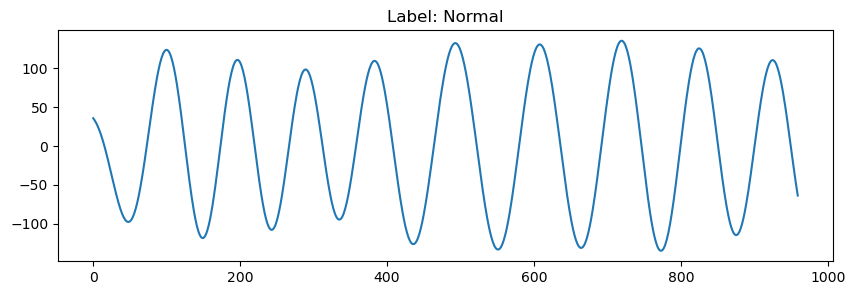

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(dataset[0]["airflow"])
plt.title(f"Label: {dataset[0]['label']}")
plt.show()

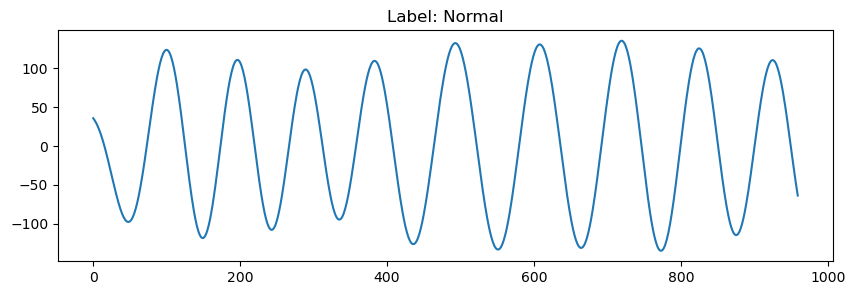

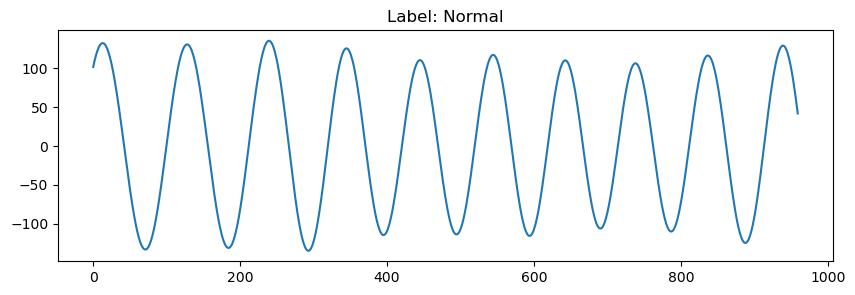

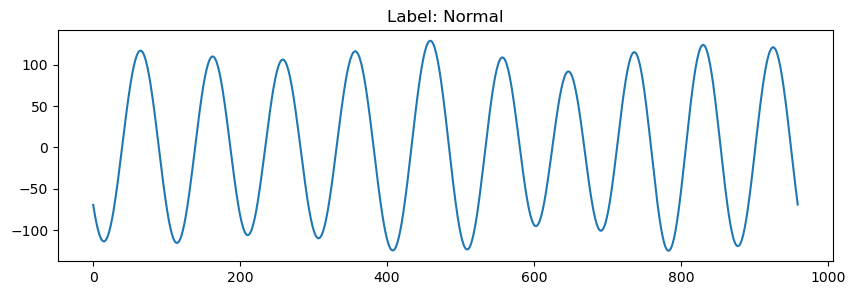

In [110]:
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(dataset[i]["airflow"])
    plt.title(f"Label: {dataset[i]['label']}")
    plt.show()

In [111]:
# Find first abnormal window
abnormal_idx = None

for i, sample in enumerate(dataset):
    if sample["label"].lower() != "normal":
        abnormal_idx = i
        break

print("First abnormal index:", abnormal_idx)
print("Label:", dataset[abnormal_idx]["label"])

First abnormal index: 679
Label: Hypopnea


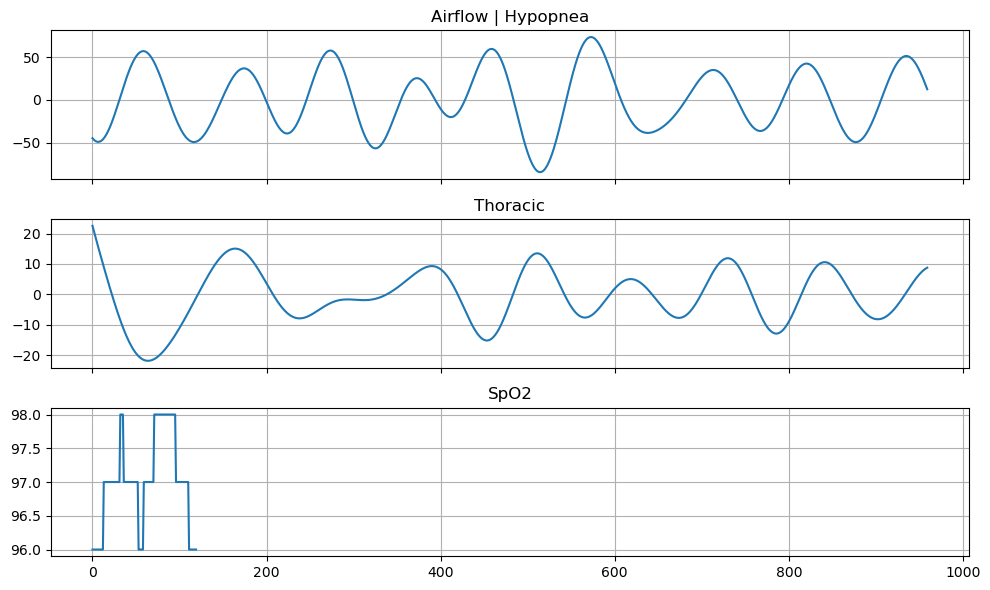

In [112]:
sample = dataset[abnormal_idx]

fig, axes = plt.subplots(3, 1, figsize=(10,6), sharex=True)

axes[0].plot(sample["airflow"])
axes[0].set_title(f"Airflow | {sample['label']}")

axes[1].plot(sample["thoracic"])
axes[1].set_title("Thoracic")

axes[2].plot(sample["spo2"])
axes[2].set_title("SpO2")

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

In [113]:
target_classes = [
    "Normal",
    "Body event",
    "Hypopnea",
    "Mixed Apnea",
    "Obstructive Apnea"
]

class_samples = {}

for sample in dataset:
    label = sample["label"]

    if label in target_classes and label not in class_samples:
        class_samples[label] = sample

    if len(class_samples) == len(target_classes):
        break

print("Found classes:", list(class_samples.keys()))

Found classes: ['Normal', 'Hypopnea', 'Obstructive Apnea', 'Body event', 'Mixed Apnea']


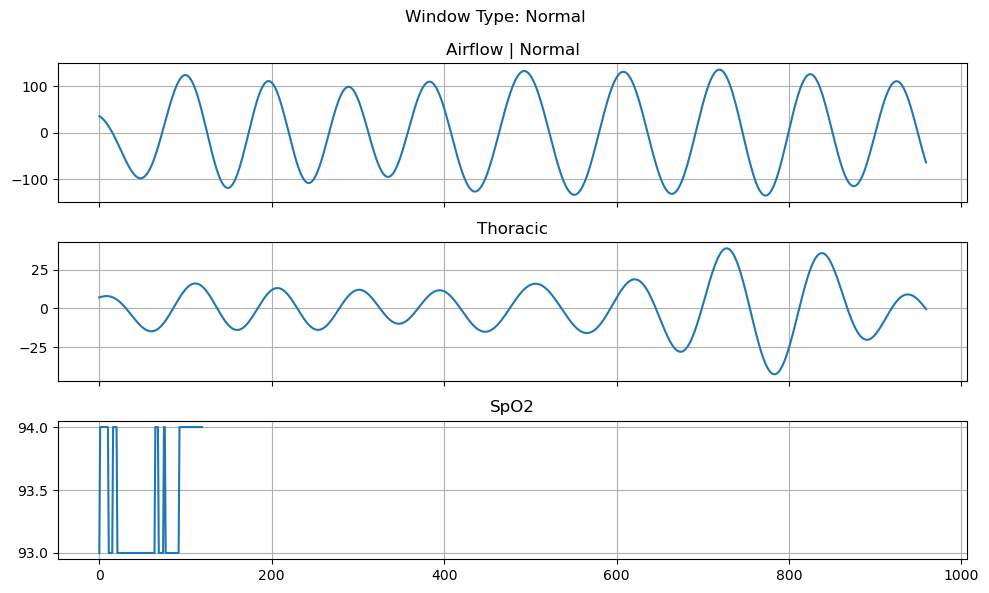

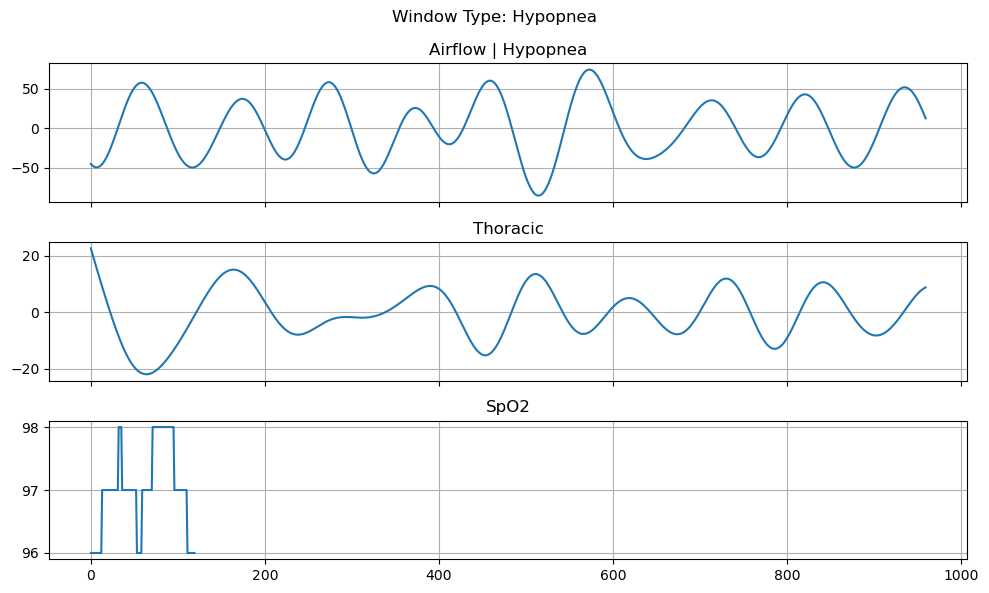

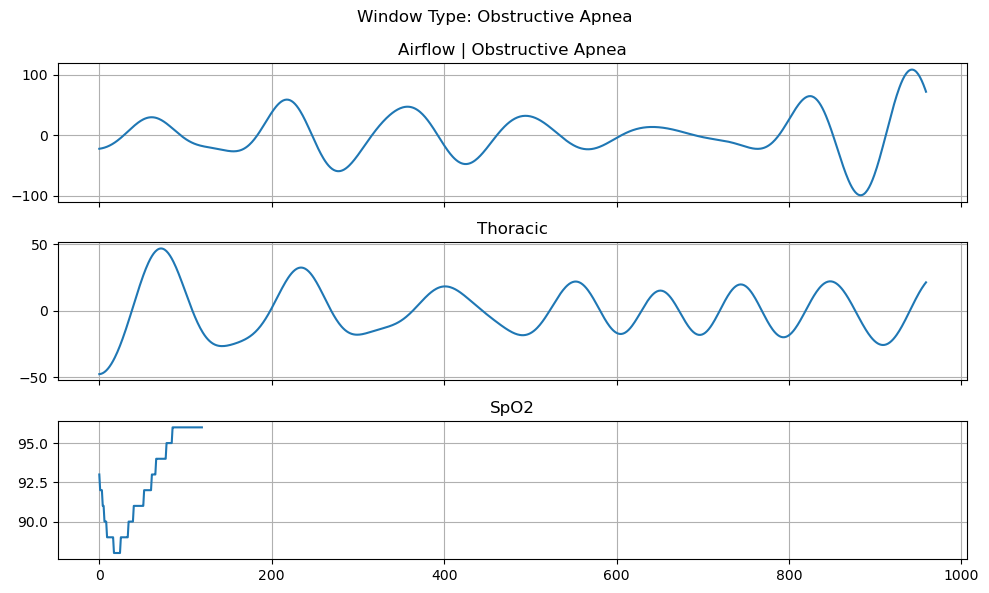

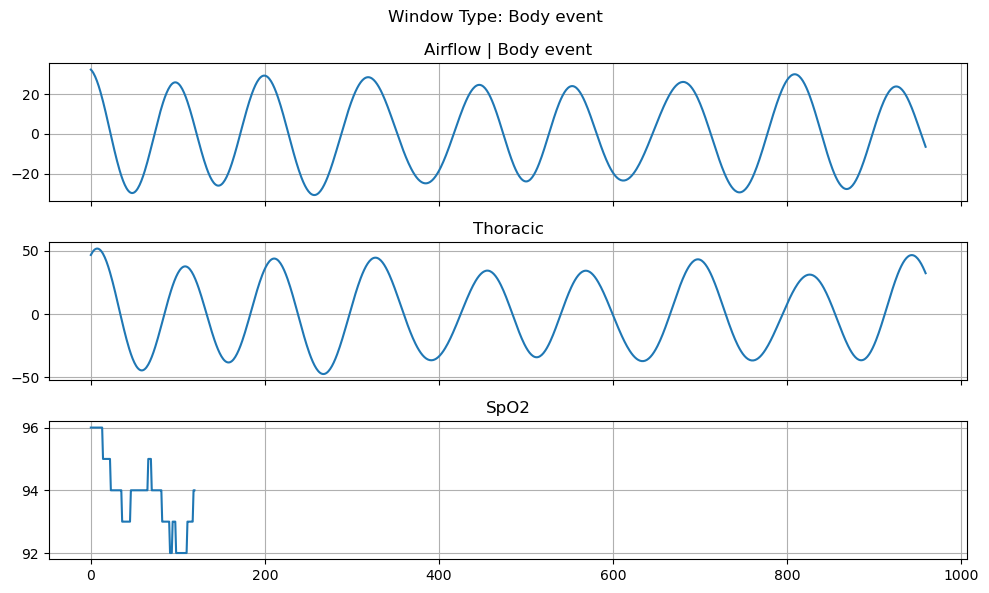

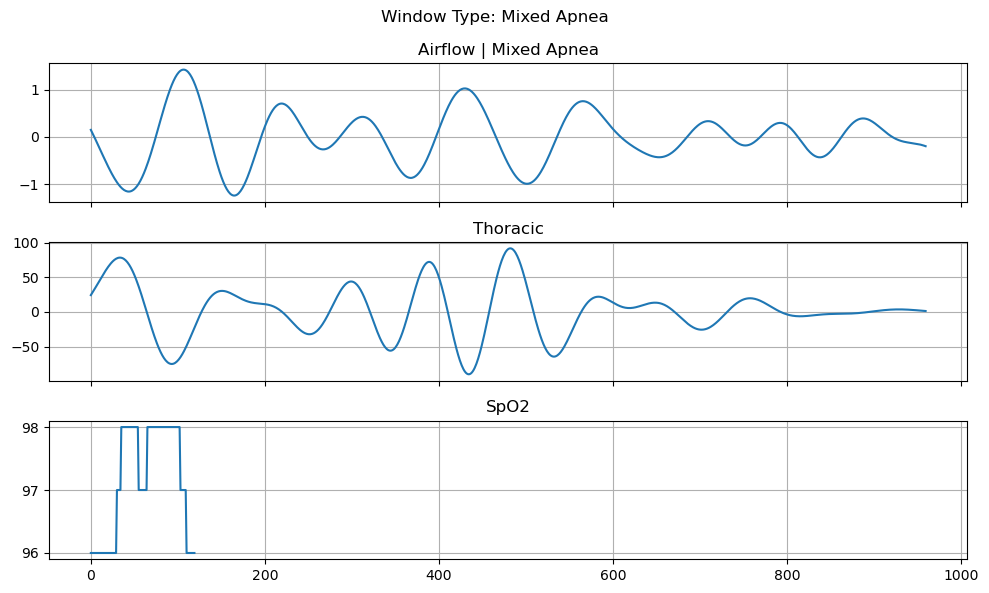

In [84]:
import matplotlib.pyplot as plt

for label, sample in class_samples.items():
    fig, axes = plt.subplots(3, 1, figsize=(10,6), sharex=True)

    axes[0].plot(sample["airfow"])
    axes[0].set_title(f"Airflow | {label}")

    axes[1].plot(sample["thoracic"])
    axes[1].set_title("Thoracic")

    axes[2].plot(sample["spo2"])
    axes[2].set_title("SpO2")

    for ax in axes:
        ax.grid(True)

    plt.suptitle(f"Window Type: {label}", fontsize=12)
    plt.tight_layout()
    plt.show()